# CS585 Problem Set 3 (Total points: 30 + 5 bonus)

Assignment adapted from Svetlana Lazebnik

### Instructions

1.  Assignment is due at **5 PM on Tuesday Feb 22 2022**.

2.  Submission instructions:

    1.  A single `.pdf` report that contains your work. Your response for all
        questions should be electronic (no handwritten responses allowed). You
        should respond to the questions individually and include images as
        necessary. Your response in the PDF report should be self-contained. It
        should include all the output you want us to look at. You will not
        receive credit for any results you have obtained, but failed to include
        directly in the PDF report file. 

        PDF file should be submitted to
        [Gradescope](https://www.gradescope.com) under `PS3`. Please tag the reponses in your PDF with the Gradescope
        questions outline  as described in
        [Submitting an Assignment](https://youtu.be/u-pK4GzpId0). 

    2.  You also need to submit code in the form of a single
        `.zip` file that includes all your code, all in the same
        directory. You can submit Python code in
        `.ipynb` format. Code should also be submitted to
        [Gradescope](https://www.gradescope.com) under `PS3-Code`. 
        *Not submitting your code will lead to a loss of
        100% of the points.*

    3.  We reserve the right to take off points for not following
        submission instructions. In particular, please tag the reponses
        in your PDF with the Gradescope questions outline as described
        in [Submitting an Assignment](https://youtu.be/u-pK4GzpId0). 



### Problems

**Stitching pairs of images.** We will estimate homography transforms to register and stitch image pairs.

**Test Images:** We are providing a image pairs that you should stitch 
together. We have also provided sample output, though, keep in mind that your output may look different from the reference output depending on implementation details.



**Getting Started** Detect feature points in both images and extract descriptor of every keypoint in both images. We will use SIFT descriptors from OpenCV library. You can refer to this [tutorial](https://docs.opencv.org/4.5.1/da/df5/tutorial_py_sift_intro.html) for more details about using SIFT in OpenCV. Please use opencv version 4.5 or later.


In [1]:
# to run in google colab
import sys
if 'google.colab' in sys.modules:
    import subprocess
    subprocess.call("pip install -U opencv-python".split())

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2, skimage
from scipy.spatial import distance
import scipy
import random
from skimage.transform import ProjectiveTransform, warp
import skimage.io
# some helper functions

def imread(fname):
    """
    read image into np array from file
    """
    return cv2.imread(fname)

def imread_bw(fname):
    """
    read image as gray scale format
    """
    return cv2.cvtColor(imread(fname), cv2.COLOR_BGR2GRAY)

def imshow(img):
    """
    show image
    """
    skimage.io.imshow(img)
    
def get_sift_data(img):
    """
    detect the keypoints and compute their SIFT descriptors with opencv library
    """
    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(img, None)
    kp = np.array([k.pt for k in kp])
    return kp, des

def plot_inlier_matches(ax, img1, img2, inliers):
    """
    plot the match between two image according to the matched keypoints
    :param ax: plot handle
    :param img1: left image
    :param img2: right image
    :inliers: x,y in the first image and x,y in the second image (Nx4)
    """
    res = np.hstack([img1, img2])
    ax.set_aspect('equal')
    ax.imshow(res, cmap='gray')
    ax.plot(inliers[:,2], inliers[:,3], '+r')
    ax.plot(inliers[:,0] + img1.shape[1], inliers[:,1], '+r')
    ax.plot([inliers[:,2], inliers[:,0] + img1.shape[1]],
            [inliers[:,3], inliers[:,1]], 'r', linewidth=0.4)


1.  **Putative Matches [5 pts].** Select putative matches based on the matrix of pairwise descriptor distances.  First, Compute distances between every descriptor in one image and every descriptor in the other image. We will use `scipy.spatial.distance.cdist(X, Y, 'sqeuclidean')`. Then, you can select all pairs  whose descriptor distances are below a specified threshold, or select the top few hundred descriptor pairs with the smallest pairwise distances. In your report, display the putative matches overlaid on the image pairs.
    

(295, 4)


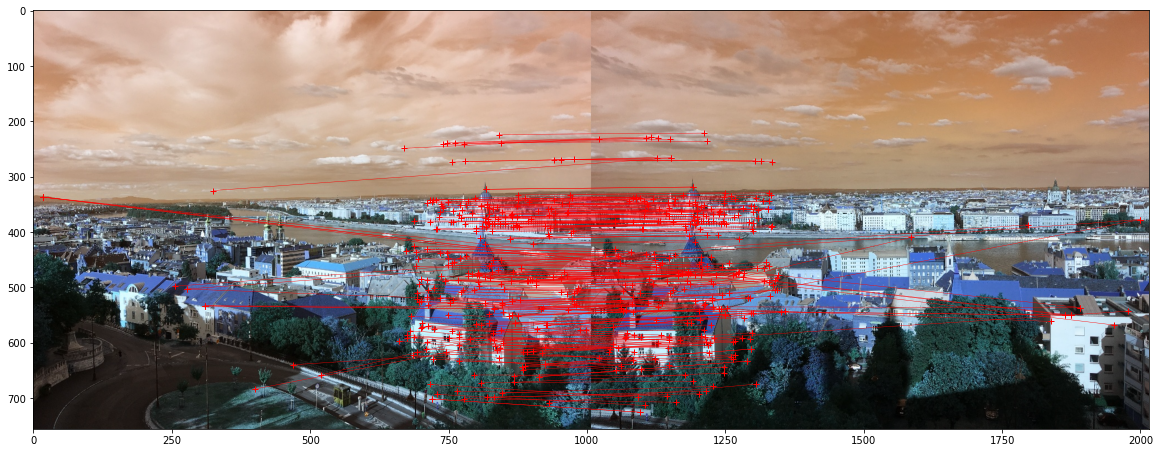

In [3]:
def get_best_matches(img1, img2, num_matches):
    kp1, des1 = get_sift_data(img1)
    kp2, des2 = get_sift_data(img2)
    # Find distance between descriptors in images
    dist = scipy.spatial.distance.cdist(des1, des2, 'sqeuclidean')
    
    # Write your code to get the matches according to dist
    threshold = 23000
    D1 = np.nonzero(dist < threshold)[0]
    D2 = np.nonzero(dist < threshold)[1]
    KP1 = np.array([kp1[i] for i in D1])
    KP2 = np.array([kp2[i] for i in D2])
    Ps = np.append(KP2, KP1, axis=1)
    print(Ps.shape)
    return Ps

    
img1 = imread('./stitch/stitch/left.jpg')
img2 = imread('./stitch/stitch/right.jpg')

data = get_best_matches(img1, img2, 300)
fig, ax = plt.subplots(figsize=(20,10))
plot_inlier_matches(ax, img1, img2, data)
#fig.savefig('sift_match.pdf', bbox_inches='tight')

2.  **Homography Estimation and RANSAC [20 pts].** Implement RANSAC to estimate a homography mapping one image onto the other. Describe the various implementation details, and report all the hyperparameters, the number of inliers, and the average residual for the inliers (mean squared distance between the point coordinates in one image and the transformed coordinates of the matching point in the other image). Also, display the locations of inlier matches in both images.
        
  **Hints:** For RANSAC, a very simple implementation is sufficient. Use four matches to initialize the homography in each iteration. You should output a single transformation that gets the most inliers in the course of all the iterations. For the various RANSAC parameters (number of iterations, inlier threshold), play around with a few reasonable values and pick the ones that work best. Homography fitting calls for homogeneous least squares. The solution to the homogeneous least squares system $AX = 0$ is obtained from the SVD of $A$ by the singular vector corresponding to the smallest singular value. In Python, `U, S, V = numpy.linalg.svd(A)` performs the singular value decomposition (SVD). This function decomposes A into $U, S, V$ such that $A = USV$ (and not $USV^T$) and `V[−1,:]` gives the right singular vector corresponding to the smallest singular value. *Your implementation should not use any opencv functions.*
    

ransac is running...... already change the iteration from 10000 to 1000 for less time
Average Residual:  93.76102741124167
The best model is: 
 [[ 3.25092576e-01 -1.03203062e-02  6.61392988e+02]
 [-2.24828771e-01  8.79740461e-01  4.53196920e+01]
 [-6.67790610e-04  7.03563107e-06  1.00000000e+00]]
Inliers: 275


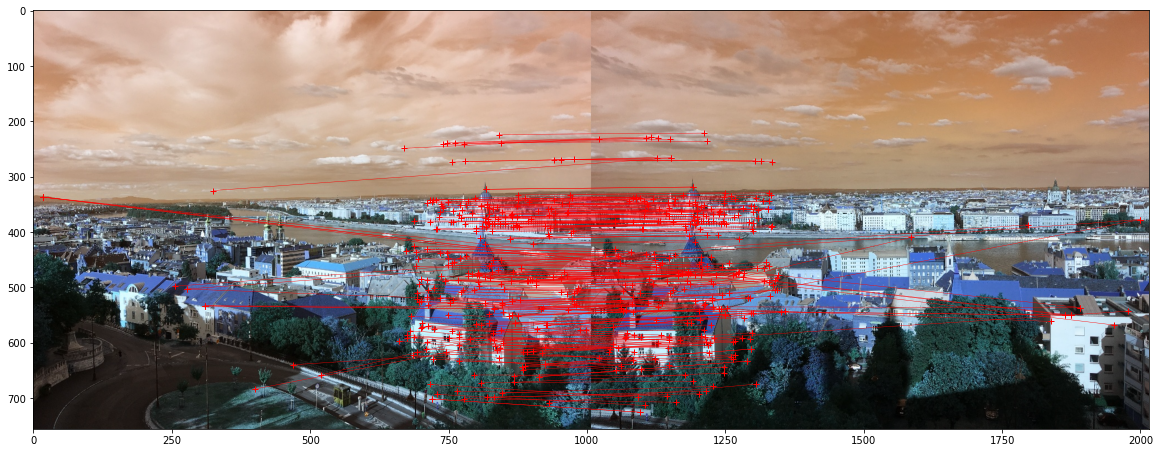

In [11]:
def ransac(data, max_iters=1000,  min_inliers=10):
    """
    write your ransac code to find the best model, inliers, and residuals
    """
    print("ransac is running...... already change the iteration from 10000 to 1000 for less time")
    max_inliers = []
    averageResidual = 0
    round = 0
    bestH = None
    dataLength = len(data)
    
    while round < max_iters:
        totalResidual = 0
        curInliers = []
        round += 1
        indexR1 = random.randrange(0, dataLength)
        indexR2 = random.randrange(0, dataLength)
        indexR3 = random.randrange(0, dataLength)
        indexR4 = random.randrange(0, dataLength)
        match1 = data[indexR1]
        match2 = data[indexR2]
        match3 = data[indexR3]
        match4 = data[indexR4]
        
        matches = np.vstack((match1, match2))
        matches = np.vstack((matches, match3))
        matches = np.vstack((matches, match4))
        model = compute_homography(matches)
        
        for i in data:
            residual = getResidual(i, model)
            if residual < 3:
                curInliers.append(i)
            totalResidual += residual
            
        #replace the max_inliers with the current inliers    
        if len(curInliers) > len(max_inliers):
            bestH = model
            max_inliers = curInliers
            #recalculate the current average residual
            averageResidual = totalResidual / dataLength
            
    print("Average Residual: ", averageResidual)
    print("The best model is: \n", bestH)
    return bestH, max_inliers

def compute_homography(matches):
    """
    write your code to compute homography according to the matches
    """
    PH = []
    for i in matches:
        M = np.matrix([i[0], i[1], 1])
        N = np.matrix([i[2], i[3], 1])
        PMatrix1 = [-N.item(2) * M.item(0), -N.item(2) * M.item(1), -N.item(2) * M.item(2), 0, 0, 0,
              N.item(0) * M.item(0), N.item(0) * M.item(1), N.item(0) * M.item(2)]
        PH.append(PMatrix1)
        PMatrix2 = [0, 0, 0, -N.item(2) * M.item(0), -N.item(2) * M.item(1), -N.item(2) * M.item(2),
              N.item(1) * M.item(0), N.item(1) * M.item(1), N.item(1) * M.item(2)]
        PH.append(PMatrix2)

    PH = np.matrix(PH)
    
    U, S, V = np.linalg.svd(PH)
    length = len(V) - 1
    H = V[length].reshape(3, 3)
    Homography = (1/H.item(8)) * H
    return Homography

def getResidual(match, H):
    
    p1 = np.matrix([match[0], match[1], 1])
    p2 = np.matrix([match[2], match[3], 1])
    
    transformed = np.dot(H, np.transpose(p1))
    ratio = 1/transformed.item(2)
    processedP2 = ratio*transformed
    residual = np.linalg.norm(np.transpose(p2) - processedP2)
    return residual

H, max_inliers = ransac(data)
print("Inliers:", len(max_inliers))
fig, ax = plt.subplots(figsize=(20,10))
plot_inlier_matches(ax, img1, img2, data)

3.  **Image Warping [5 pts].** Warp one image onto the other using the estimated transformation. You can use opencv functions for this purpose.

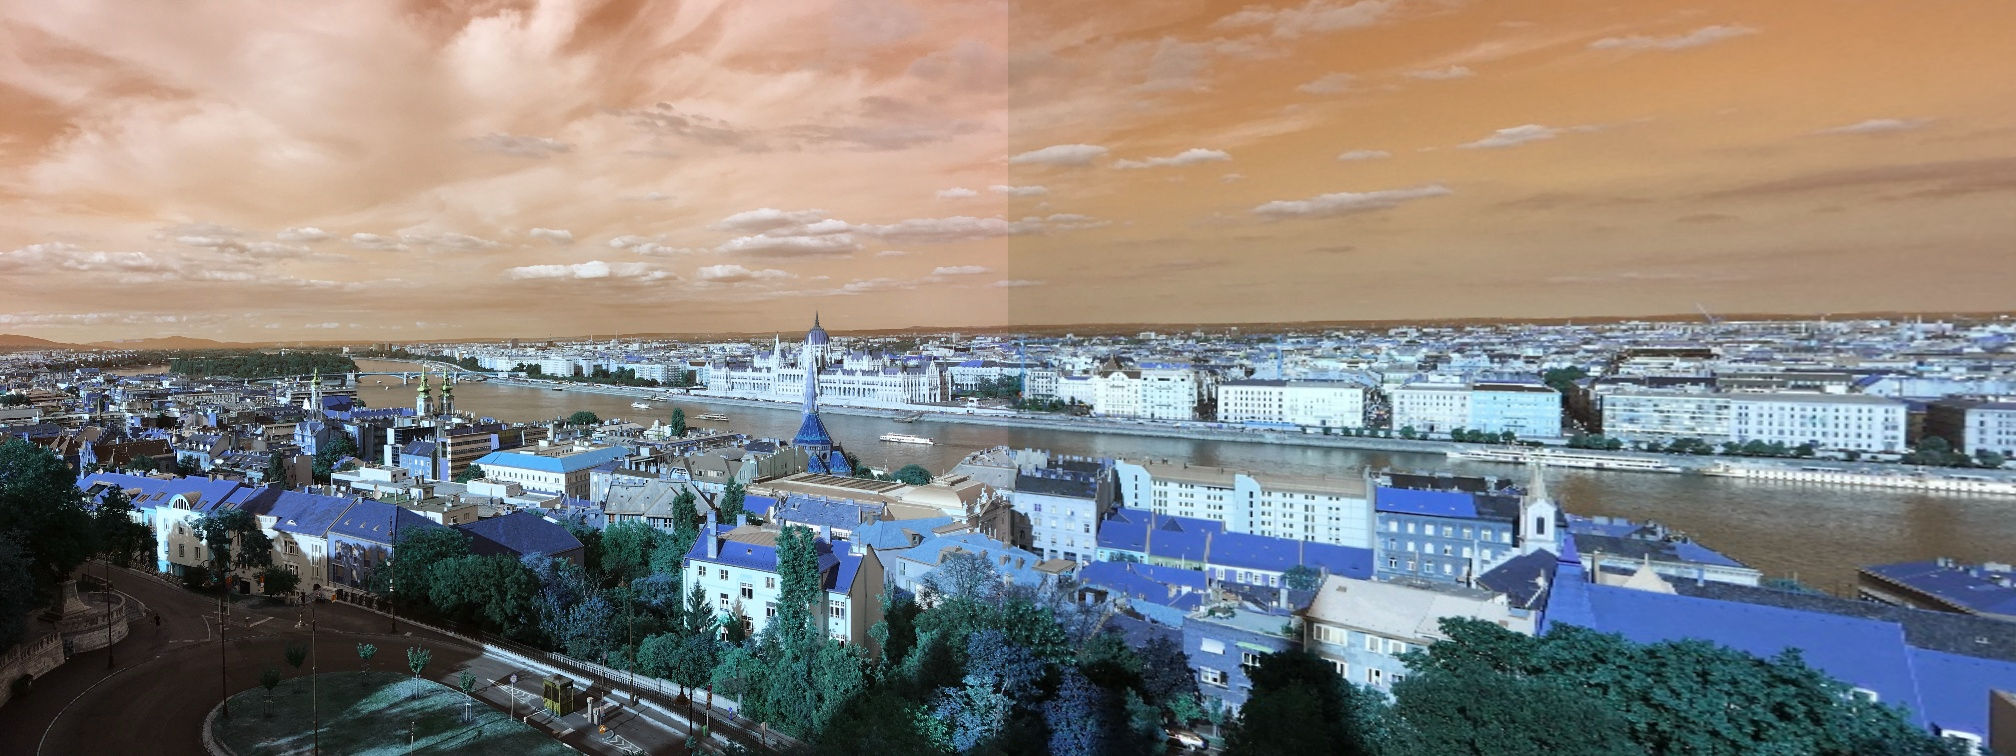

In [6]:
from PIL import Image
from IPython.display import display

def warp_images(img1, img2, H):
    """
    write your code to stitch images together according to the homography
    """
    Height = img1.shape[0]
    Width =  img1.shape[1] + img2.shape[1]
    
    warpImg = cv2.warpPerspective(img2, H, (Width, Height))
    warpImg[0:Height, 0:img1.shape[1]] = img1
    return warpImg

    # display the stitching results
img_warped = warp_images(img1, img2, H)
display(Image.fromarray(img_warped))

4.  **Image Warping [5 bonus pts].** Warp one image onto the other using the estimated transformation *without opencv functions*. Create a new image big enough to hold the panorama and composite the two images into it. You can composite by averaging the pixel values where the two images overlap, or by using the pixel values from one of the images. Your result should look similar to the sample output. You should create **color panoramas** by applying  the same compositing step to each of the color channels separately (for estimating the transformation, it is sufficient to use grayscale images). You may find `ProjectiveTransform` and warp functions in `skimage.transform` useful.

In [8]:
import skimage.transform

def warp_images_noopencv(img1, img2, H):
    """
    write your code to stitch images together according to the homography
    """
    # <YOUR CODE>
    pass

# display and report the stitching results
img_warped_nocv = warp_images_noopencv(img1, img2, H)
display(Image.fromarray(img_warped_nocv))

TypeError: Cannot handle this data type: (1, 1, 3), <i4